In [1]:
import numpy as np
import pandas as pd
from scipy.stats import describe
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

In [2]:
# disable warnings in Anaconda
import warnings

warnings.simplefilter('ignore')

In [3]:
# plots inisde jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set()

In [5]:
# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

In [6]:
# increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

In [7]:
import pandas as pd
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
import warnings

warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

In [8]:
df_train = pd.read_csv('train.csv')

In [9]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Convert strings to dates

In [10]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train.drop('date', axis=1, inplace=True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


## Sales for each storeitem

In [12]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [13]:
df_train = sales_by_storeitem(df_train)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


## Test data
Loading test data will allow  us to have correct scaling on entire set, and perform all necessary transformation on combined data.

In [15]:
# load data
df_test = pd.read_csv('test.csv')
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [16]:
# strings to dates
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.index = pd.DatetimeIndex(df_test['date'])
df_test.drop('date', axis=1, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
id       45000 non-null int64
store    45000 non-null int64
item     45000 non-null int64
dtypes: int64(3)
memory usage: 1.4 MB


In [17]:
# mock sales to use same transformations as in df_train
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


## Combine test and train datasets

In [18]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [19]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


## 1hot encoding weekdays and months

In [20]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index
weekday_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,
2013-01-01,0,1,0,0,0,0,0
2013-01-02,0,0,1,0,0,0,0
2013-01-03,0,0,0,1,0,0,0
2013-01-04,0,0,0,0,1,0,0
2013-01-05,0,0,0,0,0,1,0


In [21]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index
month_df.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 520 entries, weekday_0 to is_test
dtypes: bool(1), float64(500), uint8(19)
memory usage: 7.4 MB


In [23]:
assert df_total.isna().any().any() == False

## Shift sales 
Doing this on combined dataset allows us to have first value for test set already calculated.

In [24]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    """
    Shift columns in df with names in series_names by days_delta.
    
    Negative days_delta will prepend future values to current date,
    positive days_delta wil prepend past values to current date.
    """
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_delta=90):
    names = storeitems_column_names()
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [25]:
df_total = stack_shifted_sales(df_total, days_delta=-1)

In [26]:
df_total = df_total.dropna()  # this should ONLY remove 1st row
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(19)
memory usage: 14.7 MB


In [27]:
# make sure stacked and standard sales columns appear in the same order:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [28]:
df_total = df_total.reindex(columns=new_cols)

In [29]:
df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,...,21.0,20.0,17.0,20.0,28.0,36.0
2013-01-03,0,0,0,1,0,0,...,25.0,15.0,28.0,18.0,31.0,25.0
2013-01-04,0,0,0,0,1,0,...,37.0,20.0,33.0,24.0,46.0,31.0
2013-01-05,0,0,0,0,0,1,...,37.0,23.0,27.0,14.0,35.0,30.0
2013-01-06,0,0,0,0,0,0,...,37.0,29.0,20.0,24.0,34.0,35.0


In [30]:
df_total.tail()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2018-03-27,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-28,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-29,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-30,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-31,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_total.describe()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,...,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.142559,0.142559,0.143081,0.143081,0.143081,0.143081,...,51.522193,37.021410,37.613055,34.219321,60.241253,51.577023
std,0.349714,0.349714,0.350247,0.350247,0.350247,0.350247,...,18.707446,13.864136,13.968996,12.788732,21.714863,18.706826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,41.000000,29.000000,30.000000,27.000000,48.000000,41.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,52.000000,38.000000,38.000000,35.000000,61.000000,52.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,64.000000,46.000000,46.000000,42.000000,74.000000,63.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,111.000000,84.000000,81.000000,78.000000,134.000000,110.000000


In [32]:
assert df_total.isna().any().any() == False

## Scaling
With combined datasets and shifted sales, we can now correctly min-max scale all data.

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [34]:
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols
df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,...,0.189189,0.238095,0.209877,0.256410,0.208955,0.327273
2013-01-03,0,0,0,1,0,0,...,0.225225,0.178571,0.345679,0.230769,0.231343,0.227273
2013-01-04,0,0,0,0,1,0,...,0.333333,0.238095,0.407407,0.307692,0.343284,0.281818
2013-01-05,0,0,0,0,0,1,...,0.333333,0.273810,0.333333,0.179487,0.261194,0.272727
2013-01-06,0,0,0,0,0,0,...,0.333333,0.345238,0.246914,0.307692,0.253731,0.318182


In [36]:
df_total.describe()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,...,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.142559,0.142559,0.143081,0.143081,0.143081,0.143081,...,0.464164,0.440731,0.464359,0.438709,0.449562,0.468882
std,0.349714,0.349714,0.350247,0.350247,0.350247,0.350247,...,0.168536,0.165049,0.172457,0.163958,0.162051,0.170062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.369369,0.345238,0.370370,0.346154,0.358209,0.372727
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.468468,0.452381,0.469136,0.448718,0.455224,0.472727
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.576577,0.547619,0.567901,0.538462,0.552239,0.572727
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split back to train and test set
`df_total` will be still available - it will be necessary to reverse scaling on output data (sales predictions from the model)

In [37]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 1019 entries, weekday_0 to item_9_store_9_sales
dtypes: float64(1000), uint8(19)
memory usage: 14.0 MB


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 1019 entries, weekday_0 to item_9_store_9_sales
dtypes: float64(1000), uint8(19)
memory usage: 705.5 KB


## Split to X and y (for training)

In [40]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [41]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [43]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


## Shape for Keras LSTM

In [44]:
# split values to train and test, use np arrays to allow reshaping
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [45]:
# reshape inputs to be 3d, as in: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

## Training LSTM
Using features for all storeitems (stacked sales from previous day) to predict sales for one storeitem (sales for current day).

500 features, 1826 samples

In [46]:
from keras.models import Sequential, Model
from keras.layers import *

Using TensorFlow backend.


In [47]:
# model alternative 2 - double with conv1ds TODO
# https://arxiv.org/pdf/1709.05206.pdf
def build_model():
    inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
    # top pipeline
    top_lstm = LSTM(500, return_sequences=True)(inputs)
    top_dense = Dense(500, activation='relu')(top_lstm)
    # bottom pipeline
    bottom_dense = Dense(500)(inputs)
    bottom_conv1 = Conv1D(
        500, 
        kernel_size=1,
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
    )(bottom_dense)
    bottom_conv2 = Conv1D(
        1000,
        kernel_size=50,
        padding='same',
        activation='relu'
    )(bottom_conv1)
    bottom_conv3 = Conv1D(
        500,
        kernel_size=10,
        padding='same',
        activation='relu'
    )(bottom_conv2)
    bottom_pooling = AvgPool1D(
        pool_size=10, 
        padding='same'
    )(bottom_conv3)
#     bottom_reshape = Reshape(
#         target_shape=[500]
#     )(bottom_conv3)
    # concat output
    final_concat = Concatenate()([top_dense, bottom_pooling])
    final_lstm = LSTM(1000, dropout=0.2)(final_concat)
    final_dense = Dense(500)(final_lstm)
    # compile and return
    model = Model(inputs=inputs, outputs=final_dense)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mape'])
    return model

model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
history = model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=130, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Instructions for updating:
Use tf.cast instead.
Train on 1460 samples, validate on 365 samples
Epoch 1/130
 - 44s - loss: 0.1970 - mean_absolute_percentage_error: 661.0721 - val_loss: 0.1152 - val_mean_absolute_percentage_error: 22.4241
Epoch 2/130
 - 38s - loss: 0.0948 - mean_absolute_percentage_error: 383.1541 - val_loss: 0.0903 - val_mean_absolute_percentage_error: 19.4283
Epoch 3/130
 - 38s - loss: 0.0876 - mean_absolute_percentage_error: 315.2585 - val_loss: 0.0883 - val_mean_absolute_percentage_error: 18.6326
Epoch 4/130
 - 38s - loss: 0.0836 - mean_absolute_percentage_error: 311.3654 - val_loss: 0.0828 - val_mean_absolute_percentage_error: 16.5889
Epoch 5/130
 - 38s - loss: 0.0752 - mean_absolute_percentage_error: 322.4250 - val_loss: 0.0840 - val_mean_absolute_percentage_error: 15.3710
Epoch 6/130
 - 38s - loss: 0.0815 - mean_absolute_percentage_error: 465.9258 - val_loss: 0.0781 - val_mean_absolute_percentage_error: 16.4040
Epoch 7/130
 - 38s - loss: 0.0943 - mean_absolute_per

 - 38s - loss: 0.0831 - mean_absolute_percentage_error: 286.9060 - val_loss: 0.0720 - val_mean_absolute_percentage_error: 13.8570
Epoch 57/130
 - 37s - loss: 0.0758 - mean_absolute_percentage_error: 328.2318 - val_loss: 0.0682 - val_mean_absolute_percentage_error: 13.2176
Epoch 58/130
 - 39s - loss: 0.0763 - mean_absolute_percentage_error: 304.3928 - val_loss: 0.0691 - val_mean_absolute_percentage_error: 13.9256
Epoch 59/130
 - 39s - loss: 0.0795 - mean_absolute_percentage_error: 331.0011 - val_loss: 0.0718 - val_mean_absolute_percentage_error: 13.3153
Epoch 60/130
 - 40s - loss: 0.0710 - mean_absolute_percentage_error: 280.1521 - val_loss: 0.0696 - val_mean_absolute_percentage_error: 14.3629
Epoch 61/130
 - 40s - loss: 0.0798 - mean_absolute_percentage_error: 310.2656 - val_loss: 0.0708 - val_mean_absolute_percentage_error: 13.3120
Epoch 62/130
 - 40s - loss: 0.0741 - mean_absolute_percentage_error: 330.8218 - val_loss: 0.0691 - val_mean_absolute_percentage_error: 13.5579
Epoch 63/130

Epoch 114/130
 - 37s - loss: 0.0678 - mean_absolute_percentage_error: 326.8290 - val_loss: 0.0667 - val_mean_absolute_percentage_error: 12.6534
Epoch 115/130
 - 37s - loss: 0.0664 - mean_absolute_percentage_error: 315.4751 - val_loss: 0.0648 - val_mean_absolute_percentage_error: 12.4681
Epoch 116/130
 - 37s - loss: 0.0692 - mean_absolute_percentage_error: 328.6462 - val_loss: 0.0678 - val_mean_absolute_percentage_error: 12.7897
Epoch 117/130
 - 37s - loss: 0.0666 - mean_absolute_percentage_error: 321.9313 - val_loss: 0.0656 - val_mean_absolute_percentage_error: 12.4871
Epoch 118/130
 - 37s - loss: 0.0679 - mean_absolute_percentage_error: 331.1121 - val_loss: 0.0671 - val_mean_absolute_percentage_error: 12.6741
Epoch 119/130
 - 37s - loss: 0.0668 - mean_absolute_percentage_error: 325.6343 - val_loss: 0.0661 - val_mean_absolute_percentage_error: 12.5429
Epoch 120/130
 - 37s - loss: 0.0676 - mean_absolute_percentage_error: 329.4017 - val_loss: 0.0674 - val_mean_absolute_percentage_error: 

In [49]:
# save model
model.save('CNN_LSTM.h5')

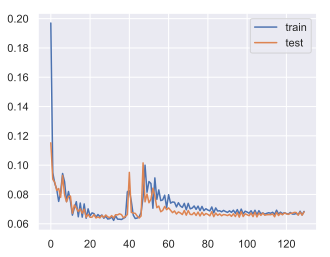

In [50]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Calculate SMAPE for the model

In [51]:
X_valid.shape

(365, 519)

In [52]:
y_valid.shape

(365, 500)

In [53]:
def model_eval(model, X_test, y_test, log_all=False):
    """
    Model must have #predict method.
    X_test, y_test - instances of pd.DataFrame (normal, not reshaped for LSTM !!!)
    
    Note that this function assumes that sales columns for previous values appear 
    in the same order as sales columns for current values.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        if log_all:
            print('[x]', x_next)
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0]
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values

def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

Prepare data for calculating SMAPE scores:

In [54]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

In [55]:
y_pred, y_real = model_eval(model, X_valid, y_valid)

In [56]:
def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]

In [57]:
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

pred = unscale(y_pred, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

Calculate SMAPE for each of the items

In [58]:
smapes = [vector_smape(pred[col], real[col]) for col in pred.columns]

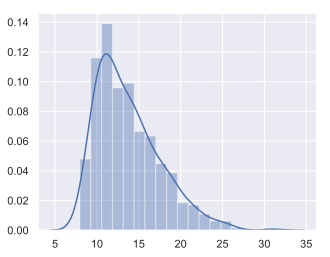

In [59]:
sns.distplot(smapes)

In [60]:
describe(smapes)

DescribeResult(nobs=500, minmax=(7.973074497693841, 31.261917063085054), mean=13.755771432623455, variance=14.403268206954843, skewness=1.0042963056592404, kurtosis=0.9393197584231463)

## Plot sample prediction

In [61]:
store, item = np.random.randint(1,11), np.random.randint(1,51)
random_storeitem_col = f'item_{item}_store_{store}_sales'

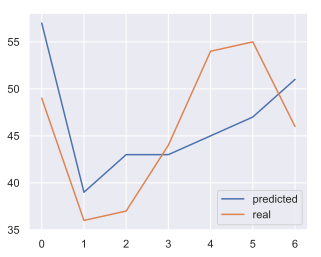

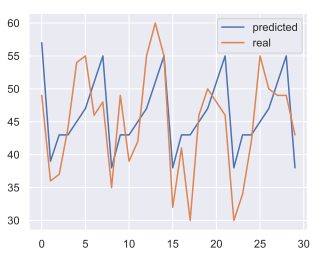

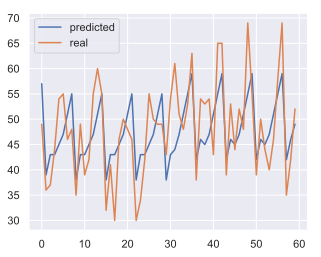

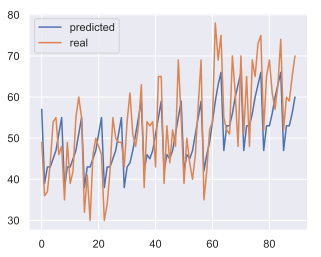

In [62]:
plot_lengths = [7, 30, 60, 365]

for pl in plot_lengths:
    plt.plot(pred[random_storeitem_col].values[:pl], label='predicted')
    plt.plot(real[random_storeitem_col].values[:pl], label='real')
    plt.legend()
    plt.show()

In [ ]:
# make sure 1st row has correctly stacked sales
df_test[stacked_sales_cols].head(2)

In [ ]:
# split to X and y
X_test, y_test = df_test[X_cols], df_test[y_cols]

In [ ]:
# y_test is basically blank, but allows us to use the same function
y_test_pred, _ = model_eval(model, X_test, y_test)

In [ ]:
test_template_df = pd.concat([X_test, y_test], axis=1)
test_template_df['is_test'] = np.repeat(True, test_template_df.shape[0])

test_pred = unscale(y_test_pred, scaler, test_template_df, toint=True)

In [ ]:
test_pred.head()

In [ ]:
plt.plot(test_pred['item_1_store_1_sales'].values)
plt.show()

In [ ]:
result = np.zeros(45000, dtype=np.int)
for i, s in storeitems():
    slice_start_idx = 90*10*(i-1) + 90*(s-1)
    slice_end_idx = slice_start_idx + 90
    col_name = f'item_{i}_store_{s}_sales'
    result[slice_start_idx:slice_end_idx] = test_pred[col_name].values
result = pd.DataFrame(result, columns=['sales'])
result.index.name = 'id'
result.head()

In [ ]:
result.to_csv('basic_lstm.csv')